Hand gesture recognition

In [1]:
%pip install tensorflow
%pip install numpy
%pip install matplotlib
%pip install opencv-python
%pip install keras
%pip install scikit-learn

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [72]:
import tensorflow as tf
import logging
tf.get_logger().setLevel(logging.ERROR)

In [73]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
main_path = './images/'
img_size = (128, 128)
batch_size = 64
num_classes=8

In [74]:
from keras.utils import image_dataset_from_directory
Xtrain = image_dataset_from_directory(main_path,
                                        subset='training',
                                        validation_split=0.2,
                                        image_size=img_size,
                                        batch_size=batch_size,
                                        seed=42)
Xval = image_dataset_from_directory(main_path,
                                        subset='validation',
                                        validation_split=0.2,
                                        image_size=img_size,
                                        batch_size=batch_size,
                                        seed=42)

classes = Xtrain.class_names

Found 2167 files belonging to 8 classes.
Using 1734 files for training.
Found 2167 files belonging to 8 classes.
Using 433 files for validation.


<Figure size 640x480 with 0 Axes>

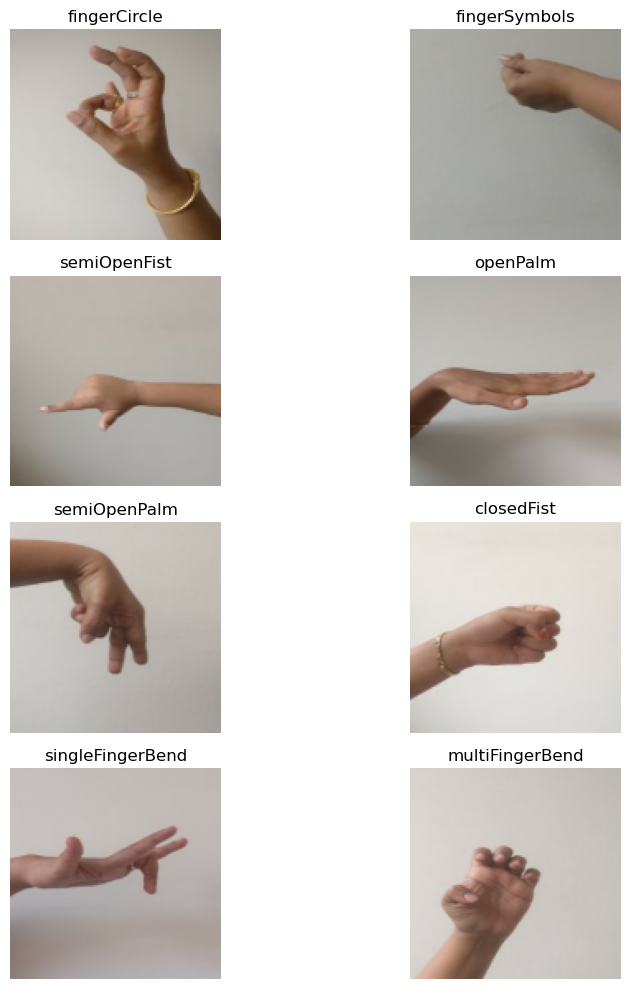

In [75]:
N = 8
plt.figure()
fig, ax = plt.subplots(4, 2, figsize=(10, 10))
seen = {}
postion = 0
for img, lab in Xtrain:
    for i in range(len(lab)):
        if classes[lab[i]] not in seen.keys():
            plt.subplot(4, int(N/4), postion+1)
            postion += 1
            plt.imshow(img[i].numpy().astype('uint8'))
            plt.title(classes[lab[i]])
            plt.axis('off')
            seen[classes[lab[i]]] = 1
fig.tight_layout()


In [76]:
class_count = {}
for img, lab in Xtrain:
    for i in range(len(lab)):
        if classes[lab[i]] in class_count.keys():
            class_count[classes[lab[i]]] += 1
        else:
            class_count[classes[lab[i]]] = 1
for img, lab in Xval:
    for i in range(len(lab)):
        if classes[lab[i]] in class_count.keys():
            class_count[classes[lab[i]]] += 1
        else:
            class_count[classes[lab[i]]] = 1
for key,val in class_count.items():
    print(key, val)


closedFist 212
semiOpenFist 361
singleFingerBend 239
fingerSymbols 529
semiOpenPalm 340
openPalm 184
fingerCircle 233
multiFingerBend 69


<BarContainer object of 8 artists>

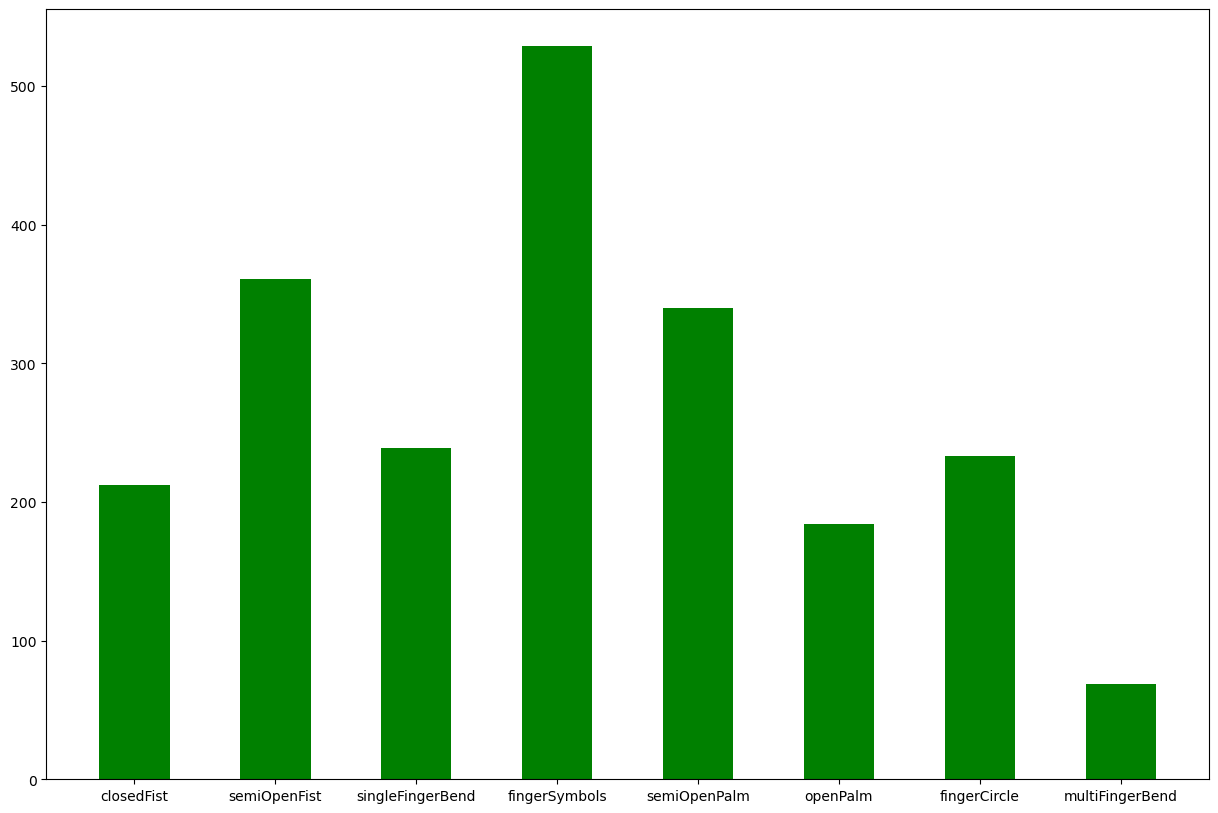

In [77]:
plt.figure(figsize=(15, 10))
plt.bar(class_count.keys(), class_count.values(), 0.5, color='g')

In [78]:
from keras import layers
from keras import Sequential
data_augmentation = Sequential(
    [
        layers.RandomFlip("horizontal_and_vertical", input_shape=(img_size[0], img_size[1], 3)),
        layers.RandomRotation(0.2),
        layers.RandomZoom(0.1),
        layers.RandomContrast(0.1)
    ]
)


<Figure size 640x480 with 0 Axes>

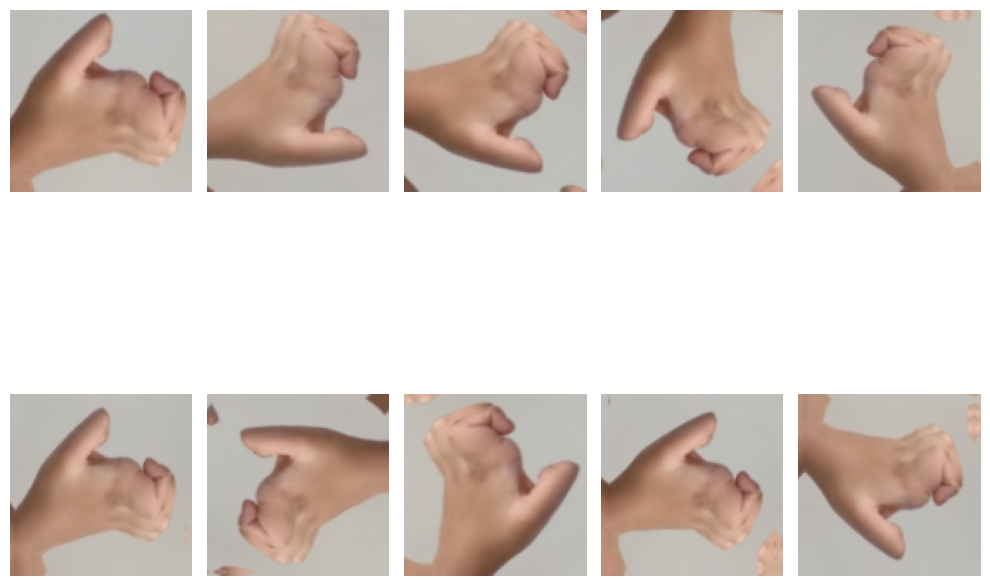

In [79]:
N = 10
plt.figure()
fig, ax = plt.subplots(4, 2, figsize=(10, 10))
for img, lab in Xtrain.take(1):
    plt.title(classes[lab[0]])
    for i in range(N):
        aug_img = data_augmentation(img)
        plt.subplot(2, int(N/2), i+1)
        plt.imshow(aug_img[0].numpy().astype('uint8'))
        plt.axis('off')
fig.tight_layout()

In [94]:
from keras import Sequential
from keras import layers
from keras.optimizers import Adam
from keras.losses import SparseCategoricalCrossentropy
num_classes = len(classes)
model = Sequential([
    data_augmentation,
    layers.Rescaling(1./255, input_shape=(img_size[0], img_size[1], 3)),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.2),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(num_classes, activation='softmax')
])
model.summary()
model.compile(Adam(learning_rate=0.001),
    loss=SparseCategoricalCrossentropy(),
    metrics='accuracy')


Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_2 (Sequential)   (None, 128, 128, 3)       0         
                                                                 
 rescaling_5 (Rescaling)     (None, 128, 128, 3)       0         
                                                                 
 conv2d_15 (Conv2D)          (None, 128, 128, 16)      448       
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 64, 64, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_16 (Conv2D)          (None, 64, 64, 32)        4640      
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 32, 32, 32)       0         
 g2D)                                                 

In [95]:
from sklearn.utils import class_weight
labels_list = []
for img, lab in Xtrain:
    for l in lab:
        labels_list.append(l)

labels = np.array(labels_list)
weights = class_weight.compute_class_weight(class_weight='balanced',
                                                classes=np.unique(labels),
                                                y=labels)
class_weights = {}
for i in range(len(weights)):
    class_weights[i] = weights[i]

In [96]:
from keras.callbacks import EarlyStopping
es = EarlyStopping(monitor='val_accuracy', patience=20, mode='max')
history = model.fit(Xtrain,
                    epochs=100,
                    validation_data=Xval,
                    callbacks=[es],
                    verbose=1)

Epoch 1/100
28/28 [==============================] - 25s 743ms/step - loss: 2.0057 - accuracy: 0.2255 - val_loss: 1.9997 - val_accuracy: 0.2379
Epoch 2/100
28/28 [==============================] - 27s 950ms/step - loss: 1.9808 - accuracy: 0.2457 - val_loss: 1.9707 - val_accuracy: 0.2379
Epoch 3/100
28/28 [==============================] - 27s 947ms/step - loss: 1.9641 - accuracy: 0.2457 - val_loss: 1.9624 - val_accuracy: 0.2471
Epoch 4/100
28/28 [==============================] - 27s 968ms/step - loss: 1.9476 - accuracy: 0.2497 - val_loss: 1.9338 - val_accuracy: 0.2356
Epoch 5/100
28/28 [==============================] - 28s 984ms/step - loss: 1.9250 - accuracy: 0.2537 - val_loss: 1.9032 - val_accuracy: 0.2517
Epoch 6/100
28/28 [==============================] - 28s 977ms/step - loss: 1.8864 - accuracy: 0.2682 - val_loss: 1.8625 - val_accuracy: 0.2725
Epoch 7/100
28/28 [==============================] - 28s 998ms/step - loss: 1.8795 - accuracy: 0.2797 - val_loss: 1.8958 - val_accuracy:

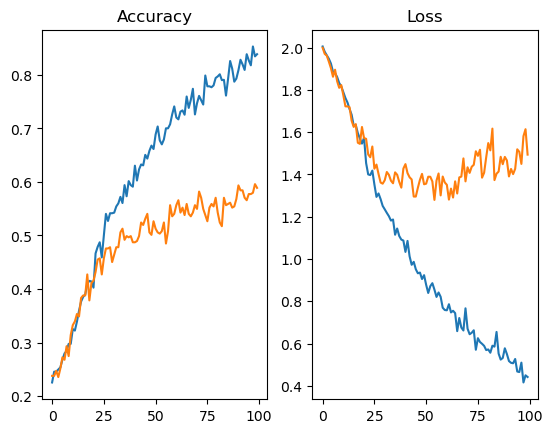

In [97]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
plt.figure()
plt.subplot(121)
plt.plot(acc)
plt.plot(val_acc)
plt.title('Accuracy')
plt.subplot(122)
plt.plot(loss)
plt.plot(val_loss)
plt.title('Loss')
plt.show()

In [98]:
def print_confusion_matrix(X):
    labels = np.array([])
    pred = np.array([])
    targetCorrect = None
    targetIncorrect = None
    classCorrect = None
    classIncorrect = None
    for img, lab in X:
        labels = np.append(labels, lab)
        pred = np.append(pred, np.argmax(model.predict(img, verbose=0), axis=1))
        
    from sklearn.metrics import accuracy_score
    print('Model accuracy: ' + str(100*accuracy_score(labels, pred)) + '%')

    from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
    cm = confusion_matrix(labels, pred, normalize='true')
    cmDisplay = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
    
    cmDisplay.plot()
    fig = cmDisplay.figure_
    fig.set_figwidth(15)
    fig.set_figheight(15)
    plt.show()


Model accuracy: 91.63783160322953%


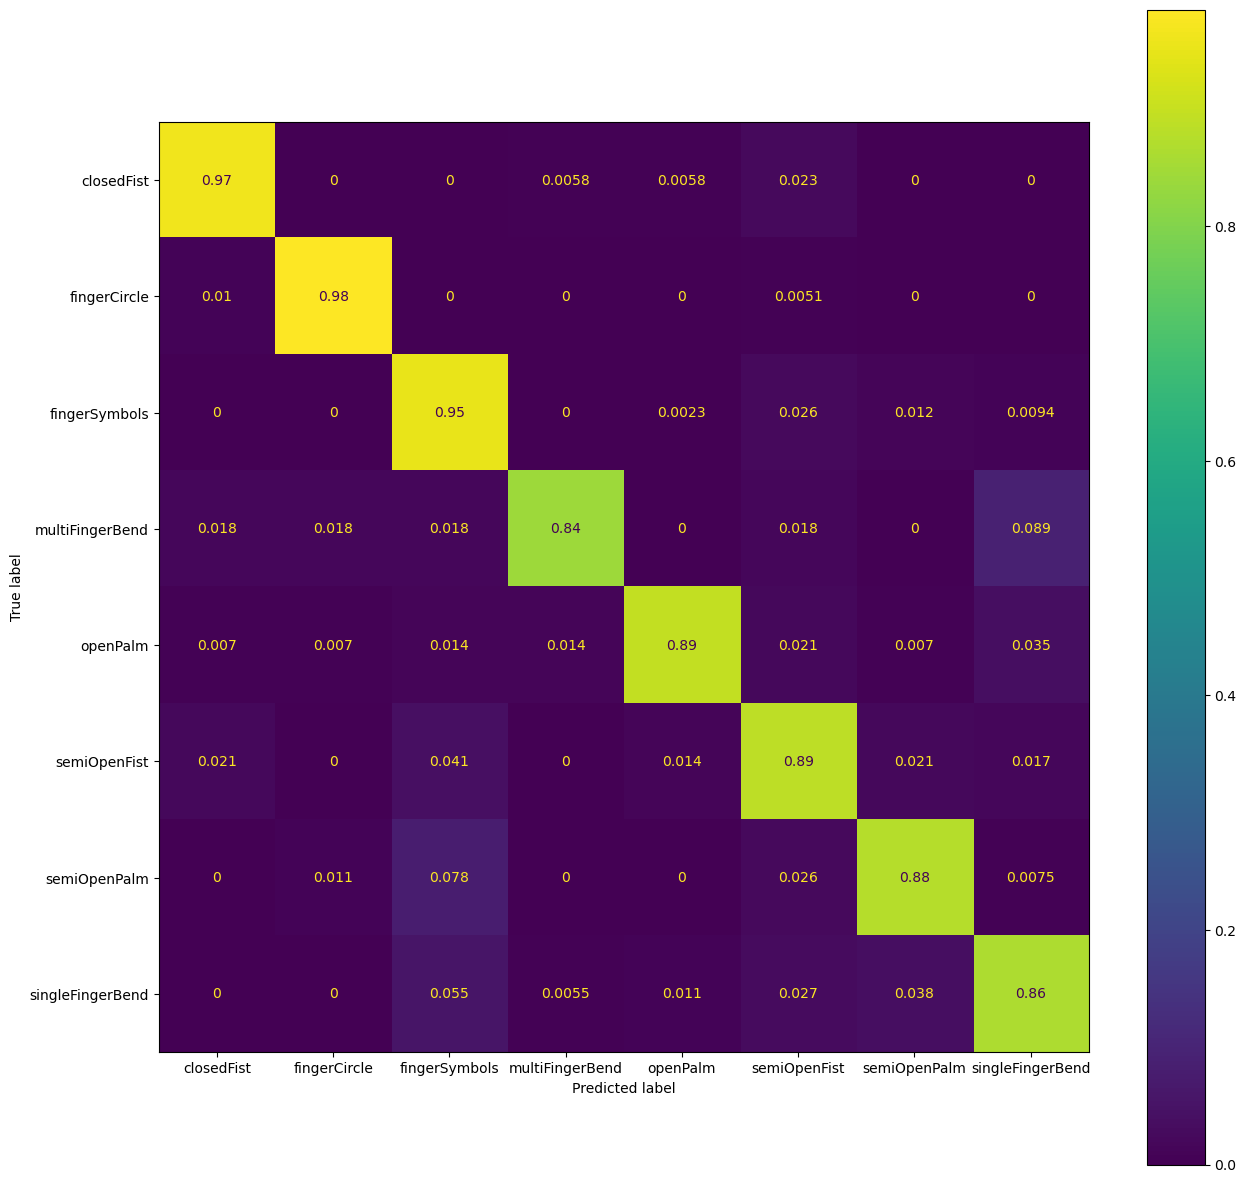

In [99]:
print_confusion_matrix(Xtrain)

Model accuracy: 58.89145496535797%


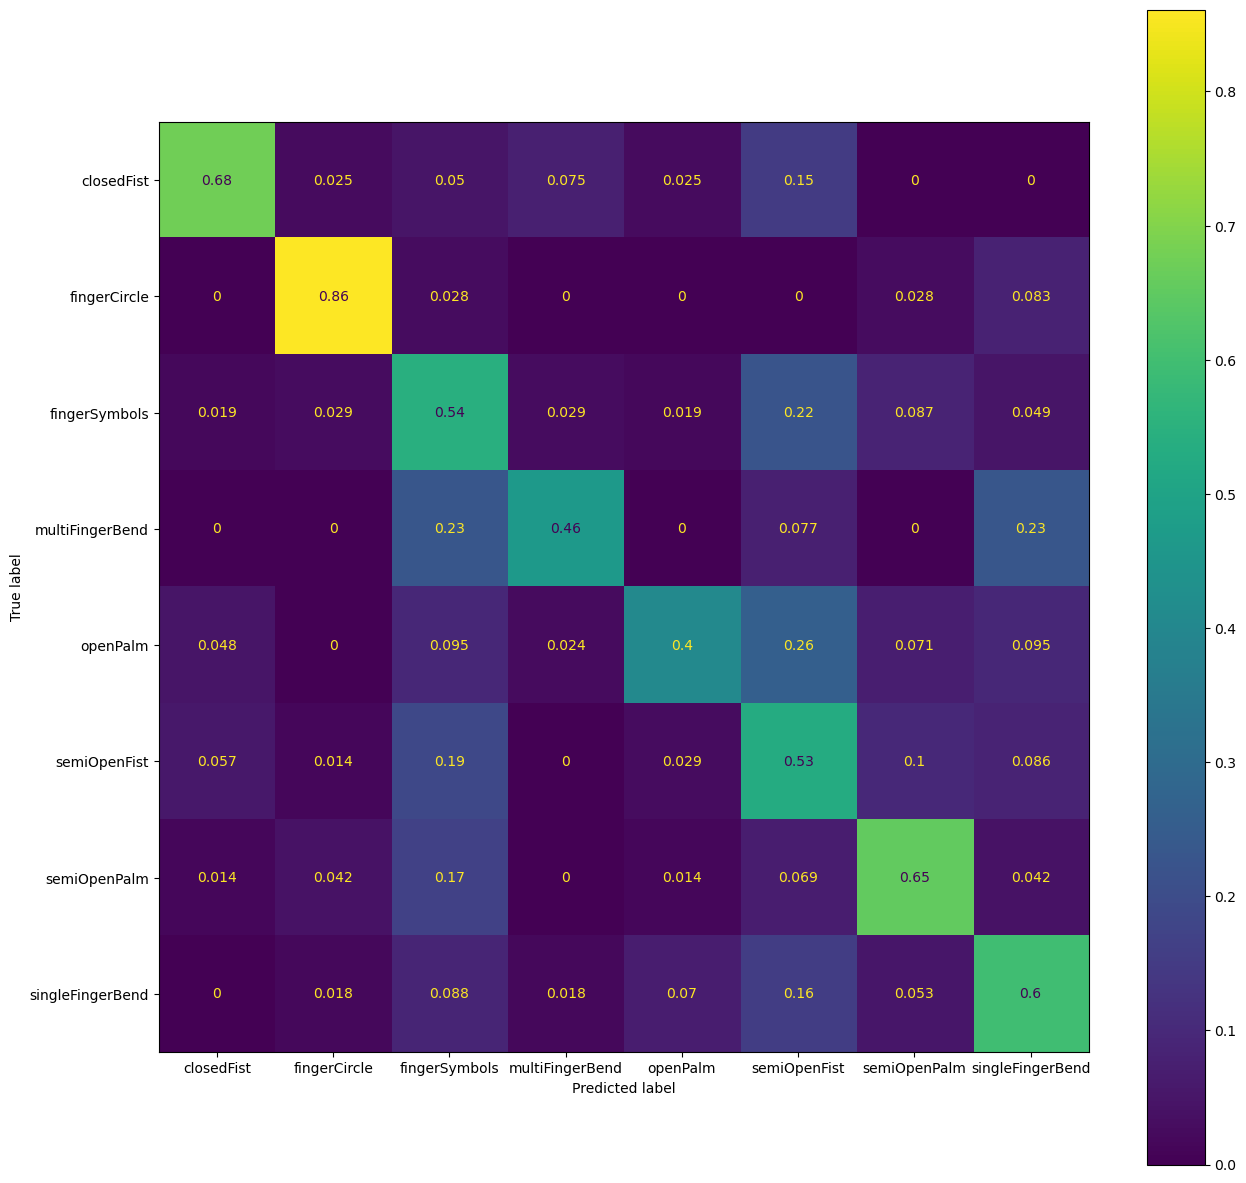

In [100]:
print_confusion_matrix(Xval)